# Tumor/T-cell model

In [7]:
from vivarium.core.composition import simulate_composer
from vivarium.plots.agents_multigen import plot_agents_multigen

from tumor_tcell.processes.tumor import test_batch_tumor
from tumor_tcell.processes.tumor import get_timeline as get_timeline_tumor
from tumor_tcell.processes.t_cell import test_batch_t_cell
from tumor_tcell.processes.t_cell import get_timeline as get_timeline_tcell
from tumor_tcell.composites.t_cell_agent import TCellAgent
from tumor_tcell.composites.tumor_agent import TumorAgent

## Processes

### Tumor


Experiment ID: d56bcc82-9317-11eb-88fe-8c85908ac627
Created: 04/01/2021 at 11:26:53
Completed in 0.395239 seconds

Experiment ID: d5a92294-9317-11eb-88fe-8c85908ac627
Created: 04/01/2021 at 11:26:54
Completed in 0.359952 seconds


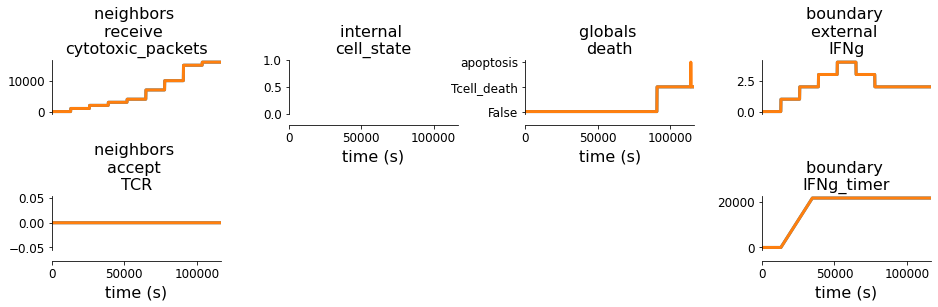

In [8]:
timeline = get_timeline_tumor()
test_batch_tumor(
#     total_time=10000,
    batch_size=2,
    timeline=timeline,
    out_dir='out')

### Tcell


Experiment ID: dc82e6cc-9317-11eb-88fe-8c85908ac627
Created: 04/01/2021 at 11:27:05
Completed in 1.07 seconds

Experiment ID: dd268a5c-9317-11eb-88fe-8c85908ac627
Created: 04/01/2021 at 11:27:06
Completed in 1.07 seconds

Experiment ID: ddcadf80-9317-11eb-88fe-8c85908ac627
Created: 04/01/2021 at 11:27:07
Completed in 1.05 seconds

Experiment ID: de6b1d92-9317-11eb-88fe-8c85908ac627
Created: 04/01/2021 at 11:27:09
Completed in 0.973891 seconds

Experiment ID: df006276-9317-11eb-88fe-8c85908ac627
Created: 04/01/2021 at 11:27:09
Completed in 1.06 seconds

Experiment ID: dfa2f0a4-9317-11eb-88fe-8c85908ac627
Created: 04/01/2021 at 11:27:11
Completed in 1.03 seconds

Experiment ID: e0403a3a-9317-11eb-88fe-8c85908ac627
Created: 04/01/2021 at 11:27:12
Completed in 1.06 seconds

Experiment ID: e0e2839e-9317-11eb-88fe-8c85908ac627
Created: 04/01/2021 at 11:27:13
Completed in 1.10 seconds

Experiment ID: e18ab5e6-9317-11eb-88fe-8c85908ac627
Created: 04/01/2021 at 11:27:14
Completed in 1.04 secon

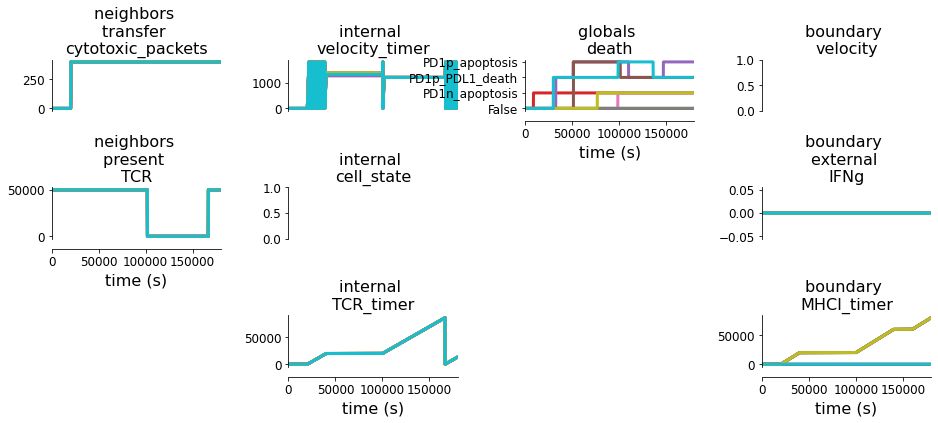

In [9]:
timeline = get_timeline_tcell()
test_batch_t_cell(
    batch_size=10,
    total_time=1000,
    timeline=timeline)

## Composites

### Tcell agent

In [14]:
total_time = 1000
agent_id = '0'
parameters = {'agent_id': agent_id}
composer = TCellAgent(parameters)

# settings for simulation and plot
initial = composer.initial_state()
initial['internal']['cell_state'] = 'PD1p'  # set an initial state
settings = {
    'initial_state': initial,
    'outer_path': ('agents', agent_id),
    'return_raw_data': True,
    'timestep': 10,
    'total_time': total_time}
tcell_agent_output = simulate_composer(composer, settings)


Experiment ID: 35895e56-8b4b-11eb-bfa9-acde48001122
Created: 03/22/2021 at 13:14:30
Completed in 0.017953 seconds


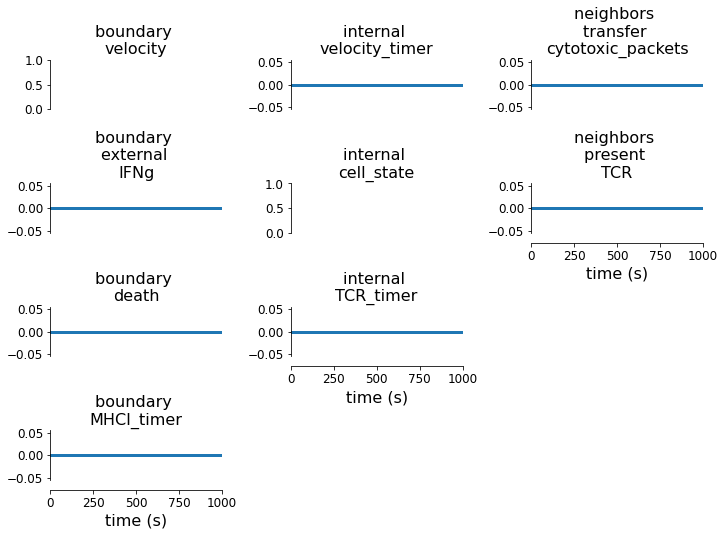

In [15]:
plot_settings = {}
fig = plot_agents_multigen(tcell_agent_output, plot_settings)

### Tumor agent

In [17]:
total_time = 1000
agent_id = '0'
parameters = {'agent_id': agent_id}
composer = TumorAgent(parameters)

# settings for simulation and plot
initial = composer.initial_state()
initial['internal']['cell_state'] = 'PD1p'  # set an initial state
settings = {
    'initial_state': initial,
    'outer_path': ('agents', agent_id),
    'return_raw_data': True,
    'timestep': 10,
    'total_time': total_time}
tumor_agent_output = simulate_composer(composer, settings)


Experiment ID: 5e791298-8b4b-11eb-bfa9-acde48001122
Created: 03/22/2021 at 13:15:38
Completed in 0.012728 seconds


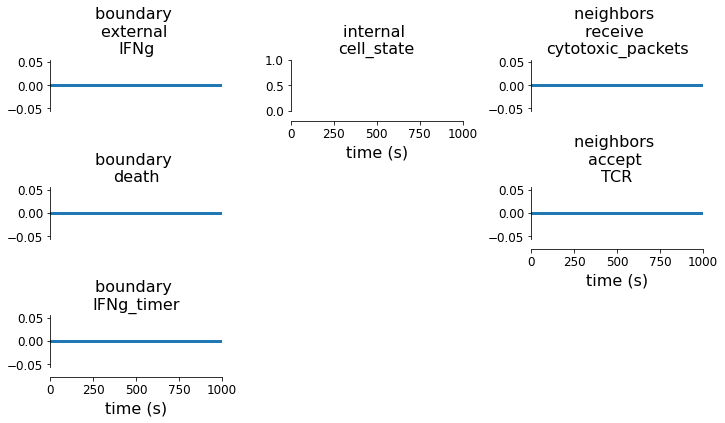

In [18]:
plot_settings = {}
fig = plot_agents_multigen(tumor_agent_output, plot_settings)

### Tumor Microenvironment

## Experiments